# Libs

In [1]:
!pip install pytorch-transformers
!pip install transformers
!pip install nltk
!pip install tweet-preprocessor
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 46.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import preprocessor as p

from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.optim import AdamW

import nltk
from nltk.stem import 	WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

2025-05-20 07:51:40.661542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747727500.840684      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747727500.890596      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Config

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
MAX_LEN = 128

# Datasets

In [5]:
# Do not use hard files in LIAR

# Train 
goss = pd.read_csv("/kaggle/input/combined/gossipcop_train.csv")
liar = pd.read_csv("/kaggle/input/combined/liar_train_covid_format.csv")[['id', 'tweet', 'label']]
poli = pd.read_csv("/kaggle/input/combined/politifact_train.csv")
covid = pd.read_csv("/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Train.csv")

# Validation
goss_val = pd.read_csv("/kaggle/input/combined/gossipcop_val.csv")
liar_val = pd.read_csv("/kaggle/input/combined/liar_valid_covid_format.csv")[['id', 'tweet', 'label']]
poli_val = pd.read_csv("/kaggle/input/combined/politifact_val.csv")
covid_val = pd.read_csv("/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Val.csv")

# Test
goss_test = pd.read_csv("/kaggle/input/combined/gossipcop_test.csv")
liar_test = pd.read_csv("/kaggle/input/combined/liar_test_covid_format.csv")[['id', 'tweet', 'label']]
poli_test = pd.read_csv("/kaggle/input/combined/politifact_test.csv")
covid_test = pd.read_csv("/kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv")

# Combine
df = pd.concat([goss, liar, poli, covid], ignore_index=True)
val_df = pd.concat([goss_val, liar_val, poli_val, covid_val], ignore_index=True)
test_df = pd.concat([goss_test, liar_test, poli_test, covid_test], ignore_index=True)

print(df.shape, val_df.shape, test_df.shape)

df.to_csv("train_combined.csv", index=False)
val_df.to_csv("val_combined.csv", index=False)
test_df.to_csv("test_combined.csv", index=False)

(32897, 3) (6903, 3) (6887, 3)


In [6]:
import re

def preprocess(row):
    text = row['tweet']
    text = p.clean(text)  # clean URL, emoji
    text = re.sub(r'\s+', ' ', text)  
    return text.strip()

# 0 if real, 1 if fake
def map_label(row):
  return 0 if row['label']=='real' else 1 

In [7]:
df['tweet'] = df.apply(preprocess, axis=1)
val_df['tweet'] = val_df.apply(preprocess, axis=1)
test_df['tweet'] = test_df.apply(preprocess, axis=1)

In [8]:
df['label_encoded'] = df.apply(lambda x: map_label(x), 1)
val_df['label_encoded'] = val_df.apply(lambda x: map_label(x), 1)
test_df['label_encoded'] = test_df.apply(lambda x: map_label(x), 1)

train_sentences = df.tweet.values
val_sentences = val_df.tweet.values
test_sentences = test_df.tweet.values

train_labels = df.label_encoded.values
val_labels = val_df.label_encoded.values

In [9]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [10]:
def encodeTextWithAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, 
                                         truncation=True, padding=padding_type, 
                                         return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def encodeTextWithoutAttention(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=False):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, 
                                         truncation=True, padding=padding_type, 
                                         return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids']

def getTokenizedTextWithAttentionMask(sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = encodeTextWithAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

def getTokenizedText(sentenceList, tokenizer):
    token_ids_list = []
    for sentence in sentenceList:
        token_ids = encodeTextWithoutAttention(sentence,tokenizer,MAX_LEN)
        token_ids_list.append(token_ids)
    return token_ids_list

In [11]:
train_token_ids,train_attention_masks = torch.tensor(getTokenizedTextWithAttentionMask(train_sentences,tokenizer))
val_token_ids,val_attention_masks = torch.tensor(getTokenizedTextWithAttentionMask(val_sentences,tokenizer))
test_token_ids,test_attention_masks = torch.tensor(getTokenizedTextWithAttentionMask(test_sentences,tokenizer))

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

In [12]:
BATCH_SZ = 64

In [13]:
train_data = TensorDataset(train_token_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SZ)

val_data = TensorDataset(val_token_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SZ)

test_data = TensorDataset(test_token_ids, test_attention_masks)
test_sampler = SequentialSampler(test_data)
test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SZ)

# Model

In [14]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2).cuda()

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [16]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training

Training:   0%|          | 0/20 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Epoch 1: Train Loss: 0.5048 | Train Acc: 0.7501 | Val Loss: 0.4127 | Val Acc: 0.8147


Training:   5%|▌         | 1/20 [17:32<5:33:14, 1052.35s/it]

Model saved.
Epoch 2: Train Loss: 0.4094 | Train Acc: 0.8051 | Val Loss: 0.3599 | Val Acc: 0.8417


Training:  10%|█         | 2/20 [35:15<5:17:38, 1058.80s/it]

Model saved.
Epoch 3: Train Loss: 0.3546 | Train Acc: 0.8326 | Val Loss: 0.3434 | Val Acc: 0.8480


Training:  15%|█▌        | 3/20 [52:56<5:00:16, 1059.80s/it]

Model saved.


Training:  20%|██        | 4/20 [1:10:35<4:42:29, 1059.33s/it]

Epoch 4: Train Loss: 0.3053 | Train Acc: 0.8577 | Val Loss: 0.3510 | Val Acc: 0.8475
Epoch 5: Train Loss: 0.2539 | Train Acc: 0.8861 | Val Loss: 0.4231 | Val Acc: 0.8506


Training:  25%|██▌       | 5/20 [1:28:15<4:24:55, 1059.72s/it]

Model saved.


Training:  30%|███       | 6/20 [1:45:54<4:07:09, 1059.28s/it]

Epoch 6: Train Loss: 0.2027 | Train Acc: 0.9137 | Val Loss: 0.4910 | Val Acc: 0.8491


Training:  35%|███▌      | 7/20 [2:03:34<3:49:33, 1059.53s/it]

Epoch 7: Train Loss: 0.1586 | Train Acc: 0.9350 | Val Loss: 0.5268 | Val Acc: 0.8443


Training:  35%|███▌      | 7/20 [2:21:13<4:22:17, 1210.55s/it]

Epoch 8: Train Loss: 0.1170 | Train Acc: 0.9537 | Val Loss: 0.5665 | Val Acc: 0.8401
Early stopping (no improvement after 3 epoch).


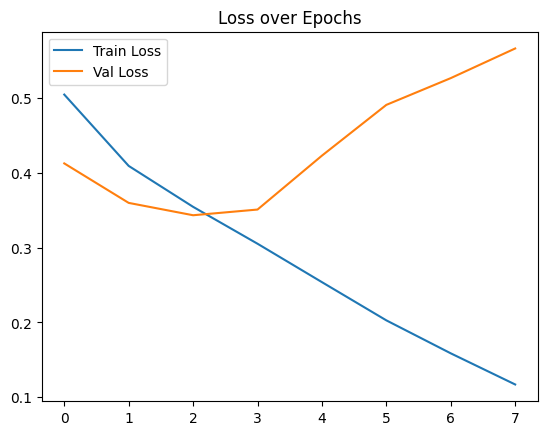

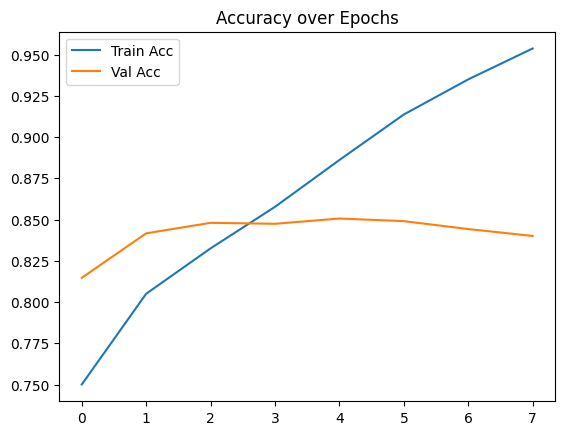

In [17]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import trange
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# Create dir
model_dir = '/kaggle/working/models'
os.makedirs(model_dir, exist_ok=True)

# Train
epochs = 20
patience = 3
early_stop_counter = 0
best_val_acc = 0.00

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in trange(epochs, desc="Training"):
    model.train()
    total_loss = 0
    preds, labels = [], []

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attn_mask, lbls = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attn_mask, labels=lbls)
        loss, logits = outputs[:2]

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        labels.extend(lbls.cpu().numpy())

    epoch_train_loss = total_loss / len(train_loader)
    epoch_train_acc = accuracy_score(labels, preds)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # Validation
    model.eval()
    val_total_loss, val_preds, val_labels = 0, [], []

    with torch.inference_mode():
        for batch in val_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attn_mask, lbls = batch

            outputs = model(input_ids, attention_mask=attn_mask, labels=lbls)
            loss, logits = outputs[:2]
            val_total_loss += loss.item()

            val_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            val_labels.extend(lbls.cpu().numpy())

    avg_val_loss = val_total_loss / len(val_loader)
    epoch_val_acc = accuracy_score(val_labels, val_preds)
    val_loss.append(avg_val_loss)
    val_acc.append(epoch_val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, "XLNet_Combined.ckpt"))
        print("Model saved.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping (no improvement after 3 epoch).")
            break

# Plotting
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()

plt.plot(train_acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()

# Test on val loader


Validation Accuracy: 0.8506

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4156
           1       0.83      0.78      0.81      2747

    accuracy                           0.85      6903
   macro avg       0.85      0.84      0.84      6903
weighted avg       0.85      0.85      0.85      6903



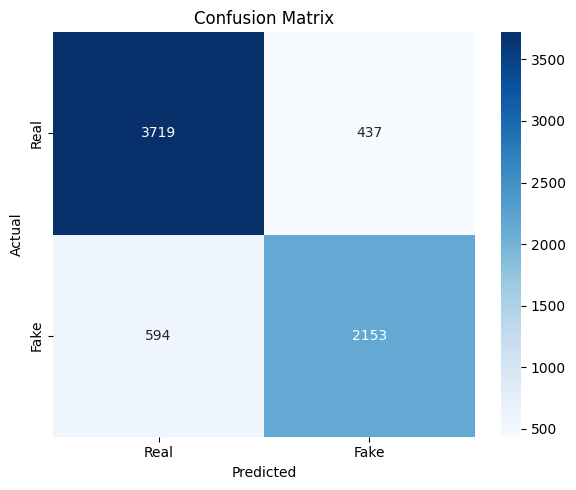

In [18]:
# === TEST ===
from sklearn.metrics import classification_report

model.load_state_dict(torch.load(os.path.join(model_dir, 'XLNet_Combined.ckpt')))
model.eval()

all_preds = []
all_labels = []

for batch in val_loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.inference_mode():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

    preds = torch.argmax(logits, dim=1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(b_labels.cpu().numpy())

# === ACCURACY + CONFUSION MATRIX ===
val_acc = accuracy_score(all_labels, all_preds)
print(f"\nValidation Accuracy: {val_acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Draw confusion matrix (0 real, 1 fake)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()